# Hyperparam Tuning Loop

In [3]:
a = [0.00000001 for i in range(4)]

In [4]:
a

[1e-08, 1e-08, 1e-08, 1e-08]

In [1]:
from unityagents import UnityEnvironment
from unityagents.exception import UnityTimeOutException
import numpy as np
import torch
import matplotlib.pyplot as plt
from ddpg_agent import Agent

from collections import deque

from pathlib import Path
#filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
#filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
filename = Path("./envs/V2//Reacher.x86_64") 
filename_abs= filename.resolve()

def start_unity_env(filename, no_graphics=True):
    env = None

    def start_unity_env_id(filename, no_graphics=True, worker_id=0):
        try:
            env = UnityEnvironment(file_name=str(filename_abs),no_graphics=no_graphics, worker_id=worker_id)
            print("Started UnityEnvironment on worker id {}".format(worker_id))
            return True, env
        except UnityTimeOutException as e:
            print(e)
            return False, None
        
    max_worker_id=10
    for i in range(max_worker_id):
        env_started, env = start_unity_env_id(filename, no_graphics=True, worker_id=i)
        if env_started:
            print(env)
            return env
    
    return None

env = start_unity_env(filename=str(filename_abs), no_graphics=True)

The Unity environment took too long to respond. Make sure that :
	 The environment does not need user interaction to launch
	 The Academy and the External Brain(s) are attached to objects in the Scene
	 The environment and the Python interface have compatible versions.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Started UnityEnvironment on worker id 1
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
env.port

AttributeError: 'NoneType' object has no attribute 'port'

In [11]:
from ray import train, tune

def run_configured_ddpg(env, config, training_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    # reset the environment
    env_info = env.reset(train_mode=train_mode)[brain_name]
    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)
    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)
    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])
    
    #ep_tot_ts = []
    n_episodes=500
    max_t=1500
    average_score_over=100
    num_agents = len(env_info.agents)
    config['num_agents']=num_agents
    
    
    agent = Agent(state_size=state_size,
                  action_size=action_size,
                  random_seed=config['random_seed'],
                  config=config,
                  device=device)


    #Load model
    load_model = False
    actor_path = 'checkpoint_actor_12p78.pth'
    critic_path = 'checkpoint_critic_12p78.pth'
    #actor_path = 'checkpoint_actor_p98.pth'
    #critic_path = 'checkpoint_critic_p98.pth'
    #actor_path = 'checkpoint_actor_p73.pth'
    #critic_path = 'checkpoint_critic_p73.pth'
    #actor_path = 'checkpoint_actor.pth'
    #critic_path = 'checkpoint_critic.pth'

    if load_model:
        agent.actor_local.load_state_dict(torch.load(actor_path))
        agent.actor_target.load_state_dict(torch.load(actor_path))
        agent.critic_local.load_state_dict(torch.load(critic_path))
        agent.critic_target.load_state_dict(torch.load(critic_path))

    #Load Score
    import pickle
    load_scores = False
    if load_scores:
        scores_deque = pickle.load(open('scores_deque.pkl', 'rb'))
        scores = pickle.load(open('scores.pkl', 'rb'))
    else:
        scores_deque = deque(maxlen=average_score_over)
        scores = []

        #===================================================================
        def run_episode(env, agent, config, num_agents, brain_name):
            env_info = env.reset(train_mode=train_mode)[brain_name]
            states = env_info.vector_observations
            agent.reset()
            agent_scores = np.zeros(num_agents) 
            #print(f'Starting Episode {i_episode}') 
            for t in range(max_t):
                #print(t)

                #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
                actions = agent.act(states, add_noise=True, noise_weight=1.0)
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done

                if t%config['train_every_ts'] == 0:
                    agent.step(states,
                               actions,
                               rewards,
                               next_states,
                               dones,
                               add_replay_flag=True,
                               learn_flag=True,
                               learn_repeat=config['train_repeated'])
                else:
                    agent.step(states,
                               actions,
                               rewards,
                               next_states,
                               dones,
                               add_replay_flag=True,
                               learn_flag=False,
                               learn_repeat=config['train_repeated'])

                states = next_states
                agent_scores += rewards
                #if True in dones:
                #    ep_tot_ts.append(t)
                #    break

                #if t % 100 == 0:
                #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))


            return agent_scores  
        
        
        def run_ddpg(agent, env, config, training_name, num_agents, brain_name):
            avg_score = 0
            best_score = 0
            for i_episode in range(1, n_episodes+1):
                agent_scores = run_episode(env, agent, config, num_agents, brain_name)

                avg_score = np.mean(agent_scores) 
                scores_deque.append(avg_score)   
                scores.append(avg_score)

                avg_100_scores = np.mean(scores_deque)

                #Save successful agents
                if avg_100_scores >= 30.0:
                        print("Success!")
                        torch.save(agent.actor_local.state_dict(), "successful_checkpoint_actor_"+training_name+".pth")   
                        torch.save(agent.critic_local.state_dict(), "successful_checkpoint_critic_"+training_name+".pth") 

                #Save every 10 episodes if current episodes greater than 
                if i_episode % 10 == 0:
                    torch.save(agent.actor_local.state_dict(), "checkpoint_actor_"+training_name+".pth")
                    torch.save(agent.critic_local.state_dict(), "checkpoint_critic_"+training_name+".pth")

                    if avg_score > best_score:
                        torch.save(agent.actor_local.state_dict(), "checkpoint_actor_best_"+training_name+".pth")
                        torch.save(agent.critic_local.state_dict(), "checkpoint_critic_best_"+training_name+".pth")
                        
                    
                    if False:
                        print("Learning Samples: mean: {} : n_sample : {}".format(agent.mean_learning_sample_reward, agent.n_learning_samples))
                        avg_rewards_learning_sample = agent.mean_learning_sample_reward/ agent.n_learning_samples
                        print('\rAverage Reward in Internal Learning Samples: {}'.format(avg_rewards_learning_sample))

                #Get average episodic scores
                if i_episode % config['print_every'] == 0:
                
                    print('\rScore Queue {},\t Mean: {:.5f}'.format(scores_deque, avg_100_scores))
                    print('\rEpisode {},\t Noise: {}'.format(i_episode,1.0))#agent.noise.state))
                    try:
                        if config['ray_tune']:
                            train.report({"avg_100_score" : avg_100_scores})
                    except KeyError:
                        pass

            return scores
        #===================================================================

    return run_ddpg(agent, env, config, training_name, num_agents, brain_name)




In [12]:
#Manual Tuning

config = {'buffer_size' : int(1e6),
          'batch_size' : 128,
          'gamma' : 0.95,
          'tau' : 1e-3,
          'lr_actor' : 1e-3,
          'lr_critic' : 1e-4,
          #'weight_decay' : 0.0,
          'weight_decay' : 0.000008,
          'theta' : 0.15,
          'random_seed' : 10,
          'train_every_ts' : 20,
          'train_repeated' : 20,
          'print_every' : 20}


tuning_run_scores = {}
#for train_every_ts in np.arange(10,20+1, step=10):
for train_every_ts in np.arange(1, 11, step=10):
    config['train_every_ts'] = train_every_ts
    
    for train_repeated in np.arange(1, 11, step=10):
        config['train_repeated'] = train_repeated
    
        for i in range(3):
            print('====================================================================')
   
        training_name='_tet_' +str(train_every_ts)+ '_tr_' +str(train_repeated)
        print(training_name)
        
        score = run_configured_ddpg(env, config, training_name)
        tuning_run_scores[training_name] = score

_tet_1_tr_1
cuda:0
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.92529297e+00 -1.00000000e+00
 -6.30408478e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  3.75728816e-01]
Score Queue deque([0.42899999041110276, 0.3854999913834035, 0.3844999914057553, 0.5839999869465828, 0.6069999864324928, 0.9184999794699251, 1.196999973244965, 1.1819999735802411, 1.3604999695904554, 1.2349999723955989, 1.4564999674446881, 1.8094999595545231, 1.7619999606162309, 2.4619999449700116,

KeyboardInterrupt: 

In [23]:
Trainable

<slot wrapper '__str__' of 'object' objects>

In [ ]:
#Ray Tuning

from ray import train, tune
from ray.tune import Trainable
from ray.air.config import RunConfig, CheckpointConfig
from ray.tune import TuneConfig

from unityagents import UnityEnvironment
from unityagents.exception import UnityTimeOutException
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from ddpg_agent import Agent

from collections import deque

from pathlib import Path

import time

class MyTrainable(Trainable):
    def setup(self, config):
        print("TRAINABLE ID", Trainable().trial_id)
        print("TRAINABLE NAME", Trainable().trial_name)
        print("TRAINABLE IP", Trainable()._local_ip)
        print("TRAINABLE IP_PID", Trainable().get_current_ip_pid())
        print("TRAINABLE STATE", Trainable().get_state())
        
        
        print("TRAINABLE ID", self.trial_id)
        print("TRAINABLE NAME", self.trial_name)
        print("TRAINABLE IP", self._local_ip)
        print("TRAINABLE IP_PID", self.get_current_ip_pid())
        print("TRAINABLE STATE", self.get_state())
        
        self.config = config
        #filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
        #filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
        filename = Path("/mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64") 
        filename_abs= filename.resolve()

        self.train_mode=True
        def start_unity_env(filename, no_graphics=True):
            env = None

            def start_unity_env_id(filename, no_graphics=True, worker_id=0):
                try:
                    env = UnityEnvironment(file_name=str(filename_abs),no_graphics=no_graphics, worker_id=worker_id)
                    print("Started UnityEnvironment on worker id {}".format(worker_id))
                    return True, env
                except UnityTimeOutException as e:
                    print(e)
                    return False, None

            max_worker_id=10
            for i in range(max_worker_id):
                env_started, env = start_unity_env_id(filename, no_graphics=True, worker_id=i)
                if env_started:
                    print(env)
                    return env
                time.sleep(1)

            return None

        self.env = start_unity_env(filename=str(filename_abs), no_graphics=True)
        self.training_name='_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])
        
        #==========================================================================
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(device)

        # get the default brain
        self.brain_name = self.env.brain_names[0]
        brain = self.env.brains[self.brain_name]
        print('Brain Name:', self.brain_name)
        print('Port:', self.env.port)
        # reset the environment
        env_info = self.env.reset(train_mode=self.train_mode)[self.brain_name]
        # number of agents
        num_agents = len(env_info.agents)
        print('Number of agents:', num_agents)
        # size of each action
        action_size = brain.vector_action_space_size
        print('Size of each action:', action_size)
        # examine the state space 
        states = env_info.vector_observations
        state_size = states.shape[1]
        print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
        print('The state for the first agent looks like:', states[0])

        #ep_tot_ts = []
        average_score_over=100
        self.num_agents = len(env_info.agents)
        config['num_agents']=num_agents


        self.agent = Agent(state_size=state_size,
                      action_size=action_size,
                      random_seed=config['random_seed'],
                      config=config,
                      device=device)


        self.scores_deque = deque(maxlen=average_score_over)
        self.scores = []
        self.best_score = 0.0
        self.i_episode = 0
        

    
    def step(self):
        
        #===================================================================

        agent_scores = self.run_episode(self.env, self.agent, self.config, self.num_agents, self.brain_name)

        avg_score = np.mean(agent_scores) 
        self.scores_deque.append(avg_score)   
        self.scores.append(avg_score)

        avg_100_scores = np.mean(self.scores_deque)

        #Save successful agents
        if avg_100_scores >= 30.0:
                print("Success!")
                torch.save(self.agent.actor_local.state_dict(), "successful_checkpoint_actor"+self.training_name+"_"+str(self.i_episode)+".pth")   
                torch.save(self.agent.critic_local.state_dict(), "successful_checkpoint_critic"+self.training_name+"_"+str(self.i_episode)+".pth") 
                pickle.dump(self.scores, open('successful_scores'+self.training_name+"_"+str(self.i_episode)+'.pkl', 'wb'))

        if avg_score > self.best_score:
            print("Saving New Best Score: {}".format(avg_score))
            torch.save(self.agent.actor_local.state_dict(), "checkpoint_actor_best"+self.training_name+"_"+str(self.i_episode)+".pth")
            torch.save(self.agent.critic_local.state_dict(), "checkpoint_critic_best"+self.training_name+"_"+str(self.i_episode)+".pth")
            self.best_score = avg_score


        if False:
            print("Learning Samples: mean: {} : n_sample : {}".format(self.agent.mean_learning_sample_reward, self.agent.n_learning_samples))
            avg_rewards_learning_sample = self.agent.mean_learning_sample_reward/ self.agent.n_learning_samples
            print('\rAverage Reward in Internal Learning Samples: {}'.format(avg_rewards_learning_sample))

        #Get average episodic scores
        if self.i_episode % self.config['print_every'] == 0:

            print('\rScore Queue {},\t Mean: {:.5f}'.format(self.scores_deque, avg_100_scores))
            print('\rEpisode {},\t Noise: {}'.format(self.i_episode,1.0))#agent.noise.state))

        self.i_episode += 1
        #==========================================================================
        
        import os
        
        results = {"avg_100_score" : avg_100_scores,
                   "best_score" : self.best_score,
                   "i_episode" : self.i_episode,
                   "episode_avg_score" : avg_score,
                   "os_cwd" :  os.getcwd()}
        return results
        
    def save_checkpoint(self, checkpoint_dir):
        torch.save(self.agent.actor_local.state_dict(), "checkpoint_actor_ray"+self.training_name+"_"+str(self.i_episode)+".pth")
        torch.save(self.agent.critic_local.state_dict(), "checkpoint_critic_ray"+self.training_name+"_"+str(self.i_episode)+".pth")
        pickle.dump(self.scores, open('scores'+self.training_name+"_"+str(self.i_episode)+'.pkl', 'wb'))
    
    def cleanup(self):
        self.env.close()
        del(self.env)
    
    def run_episode(self, env, agent, config, num_agents, brain_name):
        env_info = env.reset(train_mode=self.train_mode)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        agent_scores = np.zeros(num_agents) 
        #print(f'Starting Episode {i_episode}') 
        for t in range(config['max_t']):
            #print(t)

            #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
            actions = agent.act(states, add_noise=True, noise_weight=1.0)
            env_infos_avail = env.step(actions)
            #print('Env Infos', env_infos_avail)
            env_infos = env_infos_avail[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            if t%config['train_every_ts'] == 0:
                agent.step(states,
                           actions,
                           rewards,
                           next_states,
                           dones,
                           add_replay_flag=True,
                           learn_flag=True,
                           learn_repeat=config['train_repeated'])
            else:
                agent.step(states,
                           actions,
                           rewards,
                           next_states,
                           dones,
                           add_replay_flag=True,
                           learn_flag=False,
                           learn_repeat=config['train_repeated'])

            states = next_states
            agent_scores += rewards
            #if True in dones:
            #    ep_tot_ts.append(t)
            #    break

            #if t % 100 == 0:
            #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))


        return agent_scores  
        

config = {'buffer_size' : int(1e6),
          'batch_size' : tune.grid_search([64, 128, 256]),
          'gamma' : 0.95,
          'tau' : 1e-3,
          #'lr_actor' : 1e-3,
          #'lr_critic' : 1e-4,
          'lr_actor' : tune.grid_search([1e-2, 1e-3, 1e-4]),
          'lr_critic' : tune.grid_search([1e-3, 1e-4, 1e-5]),
          #'weight_decay' : 0.0,
          'weight_decay' : 0.000008,
          'theta' : 0.15,
          'num_agents' : 20,
          'random_seed' : 10,
          'train_every_ts' : 10,
          'train_repeated' : 40,
          'checkpoint_every_n_episodes': 100,
          'print_every' : 100,
          'max_t' : 1500,
          'ray_tune' : True}



MyTrainable_with_gpu = tune.with_resources(MyTrainable, {"gpu": 1.0})
tuner = tune.Tuner(MyTrainable_with_gpu,
                   param_space=config,
                   run_config=RunConfig(local_dir="/data1/Projects/ray_results",
                                        stop={"training_iteration": 5},
                                        log_to_file=True,
                                        checkpoint_config=CheckpointConfig(checkpoint_frequency=config['checkpoint_every_n_episodes'],
                                                                           checkpoint_at_end=True)),
                  tune_config=TuneConfig(max_concurrent_trials=1))
results = tuner.fit()

print(results.get_best_result(metric="avg_100_score", mode="min").config)

2023-10-07 21:54:12,106	INFO worker.py:1625 -- Started a local Ray instance.
2023-10-07 21:54:13,171	INFO tune.py:219 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
/home/emcy/miniconda3/envs/drlnd/lib/python3.6/site-packages/ray/tune/experiment/experiment.py:171: UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
  "The `local_dir` argument of `Experiment is deprecated. "


(MyTrainable pid=2749683) TRAINABLE ID default
(MyTrainable pid=2749683) TRAINABLE NAME default
(MyTrainable pid=2749683) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2749683) TRAINABLE IP_PID ('192.168.1.51', 2749683)
(MyTrainable pid=2749683) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2749683) TRAINABLE ID 947f8_00000
(MyTrainable pid=2749683) TRAINABLE NAME MyTrainable_947f8_00000
(MyTrainable pid=2749683) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2749683) TRAINABLE IP_PID ('192.168.1.51', 2749683)
(MyTrainable pid=2749683) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2749683) Found path: /mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64
(MyTrainable pid=2749683) Mono path[0] = '/mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher_Data/Managed'
(

(MyTrainable pid=2749683) INFO:unityagents:
(MyTrainable pid=2749683) 'Academy' started successfully!
(MyTrainable pid=2749683) Unity Academy name: Academy
(MyTrainable pid=2749683)         Number of Brains: 1
(MyTrainable pid=2749683)         Number of External Brains : 1
(MyTrainable pid=2749683)         Lesson number : 0
(MyTrainable pid=2749683)         Reset Parameters :
(MyTrainable pid=2749683) 		goal_size -> 5.0
(MyTrainable pid=2749683) 		goal_speed -> 1.0
(MyTrainable pid=2749683) Unity brain name: ReacherBrain
(MyTrainable pid=2749683)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2749683)         Vector Observation space type: continuous
(MyTrainable pid=2749683)         Vector Observation space size (per agent): 33
(MyTrainable pid=2749683)         Number of stacked Vector Observation: 1
(MyTrainable pid=2749683)         Vector Action space type: continuous
(MyTrainable pid=2749683)         Vector Action space size (per agent): 4
(MyTrainable pid=27

Trial name,avg_100_score,best_score,date,done,episode_avg_score,hostname,i_episode,iterations_since_restore,node_ip,os_cwd,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
MyTrainable_947f8_00000,0,0,2023-10-07_21-57-08,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00000_0_batch_size=64,lr_actor=0.0100,lr_critic=0.0010_2023-10-07_21-54-13",2749683,172.218,34.5145,172.218,1696730228,5,947f8_00000
MyTrainable_947f8_00001,0.15,0.75,2023-10-07_22-00-17,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00001_1_batch_size=128,lr_actor=0.0100,lr_critic=0.0010_2023-10-07_21-57-09",2752194,184.945,37.4751,184.945,1696730417,5,947f8_00001
MyTrainable_947f8_00002,0,0,2023-10-07_22-03-46,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00002_2_batch_size=256,lr_actor=0.0100,lr_critic=0.0010_2023-10-07_22-00-18",2754844,205.106,42.1091,205.106,1696730626,5,947f8_00002
MyTrainable_947f8_00003,0.15,0.75,2023-10-07_22-06-42,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00003_3_batch_size=64,lr_actor=0.0010,lr_critic=0.0010_2023-10-07_22-03-47",2757755,171.97,34.571,171.97,1696730802,5,947f8_00003
MyTrainable_947f8_00004,0,0,2023-10-07_22-09-53,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00004_4_batch_size=128,lr_actor=0.0010,lr_critic=0.0010_2023-10-07_22-06-43",2760297,186.644,37.781,186.644,1696730993,5,947f8_00004
MyTrainable_947f8_00005,0.15,0.75,2023-10-07_22-13-25,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00005_5_batch_size=256,lr_actor=0.0010,lr_critic=0.0010_2023-10-07_22-09-54",2762970,207.506,42.6563,207.506,1696731205,5,947f8_00005
MyTrainable_947f8_00006,0,0,2023-10-07_22-16-21,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00006_6_batch_size=64,lr_actor=0.0001,lr_critic=0.0010_2023-10-07_22-13-25",2765935,172.41,34.7694,172.41,1696731381,5,947f8_00006
MyTrainable_947f8_00007,0,0,2023-10-07_22-19-32,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00007_7_batch_size=128,lr_actor=0.0001,lr_critic=0.0010_2023-10-07_22-16-21",2768413,187.591,38.1186,187.591,1696731572,5,947f8_00007
MyTrainable_947f8_00008,0.3,0.75,2023-10-07_22-23-03,True,0.75,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00008_8_batch_size=256,lr_actor=0.0001,lr_critic=0.0010_2023-10-07_22-19-32",2771157,208.135,42.8797,208.135,1696731783,5,947f8_00008
MyTrainable_947f8_00009,0.3,0.75,2023-10-07_22-26-01,True,0,EmcyRook,5,5,192.168.1.51,"/mnt/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00009_9_batch_size=64,lr_actor=0.0100,lr_critic=0.0001_2023-10-07_22-23-04",2774105,174.053,35.1406,174.053,1696731961,5,947f8_00009


Score Queue deque([0.0], maxlen=100),	 Mean: 0.00000
Episode 0,	 Noise: 1.0pid=2749683) 
(MyTrainable pid=2752194) TRAINABLE ID default
(MyTrainable pid=2752194) TRAINABLE NAME default
(MyTrainable pid=2752194) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2752194) TRAINABLE IP_PID ('192.168.1.51', 2752194)
(MyTrainable pid=2752194) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2752194) TRAINABLE ID 947f8_00001
(MyTrainable pid=2752194) TRAINABLE NAME MyTrainable_947f8_00001
(MyTrainable pid=2752194) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2752194) TRAINABLE IP_PID ('192.168.1.51', 2752194)
(MyTrainable pid=2752194) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2752194) Found path: /mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64
(MyTrainable pid=2

(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         Vector Action descriptions: , , , 
(MyTrainable pid=2752194)         

Score Queue deque([0.0], maxlen=100),	 Mean: 0.00000
Episode 0,	 Noise: 1.0pid=2752194) 
(MyTrainable pid=2752194) Saving New Best Score: 0.7499999832361937
(MyTrainable pid=2754844) TRAINABLE ID default
(MyTrainable pid=2754844) TRAINABLE NAME default
(MyTrainable pid=2754844) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2754844) TRAINABLE IP_PID ('192.168.1.51', 2754844)
(MyTrainable pid=2754844) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2754844) TRAINABLE ID 947f8_00002
(MyTrainable pid=2754844) TRAINABLE NAME MyTrainable_947f8_00002
(MyTrainable pid=2754844) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2754844) TRAINABLE IP_PID ('192.168.1.51', 2754844)
(MyTrainable pid=2754844) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2754844) Found path: /mnt/da

(MyTrainable pid=2754844) INFO:unityagents:
(MyTrainable pid=2754844) 'Academy' started successfully!
(MyTrainable pid=2754844) Unity Academy name: Academy
(MyTrainable pid=2754844)         Number of Brains: 1
(MyTrainable pid=2754844)         Number of External Brains : 1
(MyTrainable pid=2754844)         Lesson number : 0
(MyTrainable pid=2754844)         Reset Parameters :
(MyTrainable pid=2754844) 		goal_size -> 5.0
(MyTrainable pid=2754844) 		goal_speed -> 1.0
(MyTrainable pid=2754844) Unity brain name: ReacherBrain
(MyTrainable pid=2754844)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2754844)         Vector Observation space type: continuous
(MyTrainable pid=2754844)         Vector Observation space size (per agent): 33
(MyTrainable pid=2754844)         Number of stacked Vector Observation: 1
(MyTrainable pid=2754844)         Vector Action space type: continuous
(MyTrainable pid=2754844)         Vector Action space size (per agent): 4
(MyTrainable pid=27

Score Queue deque([0.0], maxlen=100),	 Mean: 0.00000
Episode 0,	 Noise: 1.0pid=2754844) 
(MyTrainable pid=2757755) TRAINABLE ID default
(MyTrainable pid=2757755) TRAINABLE NAME default
(MyTrainable pid=2757755) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2757755) TRAINABLE IP_PID ('192.168.1.51', 2757755)
(MyTrainable pid=2757755) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2757755) TRAINABLE ID 947f8_00003
(MyTrainable pid=2757755) TRAINABLE NAME MyTrainable_947f8_00003
(MyTrainable pid=2757755) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2757755) TRAINABLE IP_PID ('192.168.1.51', 2757755)
(MyTrainable pid=2757755) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2757755) Found path: /mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64
(MyTrainable pid=2

(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         Vector Action descriptions: , , , 
(MyTrainable pid=2757755)         

Score Queue deque([0.0], maxlen=100),	 Mean: 0.00000
Episode 0,	 Noise: 1.0pid=2757755) 
(MyTrainable pid=2757755) Saving New Best Score: 0.7499999832361937
(MyTrainable pid=2760297) TRAINABLE ID default
(MyTrainable pid=2760297) TRAINABLE NAME default
(MyTrainable pid=2760297) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2760297) TRAINABLE IP_PID ('192.168.1.51', 2760297)
(MyTrainable pid=2760297) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2760297) TRAINABLE ID 947f8_00004
(MyTrainable pid=2760297) TRAINABLE NAME MyTrainable_947f8_00004
(MyTrainable pid=2760297) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2760297) TRAINABLE IP_PID ('192.168.1.51', 2760297)
(MyTrainable pid=2760297) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2760297) Found path: /mnt/da

(MyTrainable pid=2760297) INFO:unityagents:
(MyTrainable pid=2760297) 'Academy' started successfully!
(MyTrainable pid=2760297) Unity Academy name: Academy
(MyTrainable pid=2760297)         Number of Brains: 1
(MyTrainable pid=2760297)         Number of External Brains : 1
(MyTrainable pid=2760297)         Lesson number : 0
(MyTrainable pid=2760297)         Reset Parameters :
(MyTrainable pid=2760297) 		goal_size -> 5.0
(MyTrainable pid=2760297) 		goal_speed -> 1.0
(MyTrainable pid=2760297) Unity brain name: ReacherBrain
(MyTrainable pid=2760297)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2760297)         Vector Observation space type: continuous
(MyTrainable pid=2760297)         Vector Observation space size (per agent): 33
(MyTrainable pid=2760297)         Number of stacked Vector Observation: 1
(MyTrainable pid=2760297)         Vector Action space type: continuous
(MyTrainable pid=2760297)         Vector Action space size (per agent): 4
(MyTrainable pid=27

(MyTrainable pid=2760297) Started UnityEnvironment on worker id 0
(MyTrainable pid=2760297) Unity Academy name: Academy
(MyTrainable pid=2760297)         Number of Brains: 1
(MyTrainable pid=2760297)         Number of External Brains : 1
(MyTrainable pid=2760297)         Lesson number : 0
(MyTrainable pid=2760297)         Reset Parameters :
(MyTrainable pid=2760297) 		goal_size -> 5.0
(MyTrainable pid=2760297) 		goal_speed -> 1.0
(MyTrainable pid=2760297) Unity brain name: ReacherBrain
(MyTrainable pid=2760297)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2760297)         Vector Observation space type: continuous
(MyTrainable pid=2760297)         Vector Observation space size (per agent): 33
(MyTrainable pid=2760297)         Number of stacked Vector Observation: 1
(MyTrainable pid=2760297)         Vector Action space type: continuous
(MyTrainable pid=2760297)         Vector Action space size (per agent): 4
(MyTrainable pid=2760297)         Vector Action descrip

(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         Vector Action descriptions: , , , 
(MyTrainable pid=2762970)         

Score Queue deque([0.0], maxlen=100),	 Mean: 0.00000
Episode 0,	 Noise: 1.0pid=2762970) 
(MyTrainable pid=2762970) Saving New Best Score: 0.7499999832361937
(MyTrainable pid=2765935) TRAINABLE ID default
(MyTrainable pid=2765935) TRAINABLE NAME default
(MyTrainable pid=2765935) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2765935) TRAINABLE IP_PID ('192.168.1.51', 2765935)
(MyTrainable pid=2765935) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2765935) TRAINABLE ID 947f8_00006
(MyTrainable pid=2765935) TRAINABLE NAME MyTrainable_947f8_00006
(MyTrainable pid=2765935) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2765935) TRAINABLE IP_PID ('192.168.1.51', 2765935)
(MyTrainable pid=2765935) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2765935) Found path: /mnt/da

(MyTrainable pid=2765935) INFO:unityagents:
(MyTrainable pid=2765935) 'Academy' started successfully!
(MyTrainable pid=2765935) Unity Academy name: Academy
(MyTrainable pid=2765935)         Number of Brains: 1
(MyTrainable pid=2765935)         Number of External Brains : 1
(MyTrainable pid=2765935)         Lesson number : 0
(MyTrainable pid=2765935)         Reset Parameters :
(MyTrainable pid=2765935) 		goal_size -> 5.0
(MyTrainable pid=2765935) 		goal_speed -> 1.0
(MyTrainable pid=2765935) Unity brain name: ReacherBrain
(MyTrainable pid=2765935)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2765935)         Vector Observation space type: continuous
(MyTrainable pid=2765935)         Vector Observation space size (per agent): 33
(MyTrainable pid=2765935)         Number of stacked Vector Observation: 1
(MyTrainable pid=2765935)         Vector Action space type: continuous
(MyTrainable pid=2765935)         Vector Action space size (per agent): 4
(MyTrainable pid=27

Score Queue deque([0.0], maxlen=100),	 Mean: 0.00000
Episode 0,	 Noise: 1.0pid=2765935) 
(MyTrainable pid=2768413) TRAINABLE ID default
(MyTrainable pid=2768413) TRAINABLE NAME default
(MyTrainable pid=2768413) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2768413) TRAINABLE IP_PID ('192.168.1.51', 2768413)
(MyTrainable pid=2768413) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2768413) TRAINABLE ID 947f8_00007
(MyTrainable pid=2768413) TRAINABLE NAME MyTrainable_947f8_00007
(MyTrainable pid=2768413) TRAINABLE IP 192.168.1.51
(MyTrainable pid=2768413) TRAINABLE IP_PID ('192.168.1.51', 2768413)
(MyTrainable pid=2768413) TRAINABLE STATE {'iteration': 0, 'timesteps_total': None, 'time_total': 0.0, 'episodes_total': None, 'last_result': None, 'ray_version': '2.4.0'}
(MyTrainable pid=2768413) Found path: /mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64
(MyTrainable pid=2

(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         Vector Action descriptions: , , , 
(MyTrainable pid=2768413)         

(MyTrainable pid=2768413) Started UnityEnvironment on worker id 0
(MyTrainable pid=2768413) Unity Academy name: Academy
(MyTrainable pid=2768413)         Number of Brains: 1
(MyTrainable pid=2768413)         Number of External Brains : 1
(MyTrainable pid=2768413)         Lesson number : 0
(MyTrainable pid=2768413)         Reset Parameters :
(MyTrainable pid=2768413) 		goal_size -> 5.0
(MyTrainable pid=2768413) 		goal_speed -> 1.0
(MyTrainable pid=2768413) Unity brain name: ReacherBrain
(MyTrainable pid=2768413)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2768413)         Vector Observation space type: continuous
(MyTrainable pid=2768413)         Vector Observation space size (per agent): 33
(MyTrainable pid=2768413)         Number of stacked Vector Observation: 1
(MyTrainable pid=2768413)         Vector Action space type: continuous
(MyTrainable pid=2768413)         Vector Action space size (per agent): 4
(MyTrainable pid=2768413)         Vector Action descrip

(MyTrainable pid=2771157) INFO:unityagents:
(MyTrainable pid=2771157) 'Academy' started successfully!
(MyTrainable pid=2771157) Unity Academy name: Academy
(MyTrainable pid=2771157)         Number of Brains: 1
(MyTrainable pid=2771157)         Number of External Brains : 1
(MyTrainable pid=2771157)         Lesson number : 0
(MyTrainable pid=2771157)         Reset Parameters :
(MyTrainable pid=2771157) 		goal_size -> 5.0
(MyTrainable pid=2771157) 		goal_speed -> 1.0
(MyTrainable pid=2771157) Unity brain name: ReacherBrain
(MyTrainable pid=2771157)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2771157)         Vector Observation space type: continuous
(MyTrainable pid=2771157)         Vector Observation space size (per agent): 33
(MyTrainable pid=2771157)         Number of stacked Vector Observation: 1
(MyTrainable pid=2771157)         Vector Action space type: continuous
(MyTrainable pid=2771157)         Vector Action space size (per agent): 4
(MyTrainable pid=27

(MyTrainable pid=2771157) Number of agents: 20
(MyTrainable pid=2771157) Size of each action: 4
(MyTrainable pid=2771157) There are 20 agents. Each observes a state with length: 33
(MyTrainable pid=2771157) The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
(MyTrainable pid=2771157)  -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
(MyTrainable pid=2771157)   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
(MyTrainable pid=2771157)   0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
(MyTrainable pid=2771157)   1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
(MyTrainable pid=2771157)   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
(MyTrainable pid=2771157)   0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
(MyTrainable pid=2771157)   5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
(MyTrainable pid=2771157)  -1.68164849e-01]
Score

(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         Vector Action descriptions: , , , 
(MyTrainable pid=2774105)         

(MyTrainable pid=2774105) Started UnityEnvironment on worker id 0
(MyTrainable pid=2774105) Unity Academy name: Academy
(MyTrainable pid=2774105)         Number of Brains: 1
(MyTrainable pid=2774105)         Number of External Brains : 1
(MyTrainable pid=2774105)         Lesson number : 0
(MyTrainable pid=2774105)         Reset Parameters :
(MyTrainable pid=2774105) 		goal_size -> 5.0
(MyTrainable pid=2774105) 		goal_speed -> 1.0
(MyTrainable pid=2774105) Unity brain name: ReacherBrain
(MyTrainable pid=2774105)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2774105)         Vector Observation space type: continuous
(MyTrainable pid=2774105)         Vector Observation space size (per agent): 33
(MyTrainable pid=2774105)         Number of stacked Vector Observation: 1
(MyTrainable pid=2774105)         Vector Action space type: continuous
(MyTrainable pid=2774105)         Vector Action space size (per agent): 4
(MyTrainable pid=2774105)         Vector Action descrip

(MyTrainable pid=2776625) INFO:unityagents:
(MyTrainable pid=2776625) 'Academy' started successfully!
(MyTrainable pid=2776625) Unity Academy name: Academy
(MyTrainable pid=2776625)         Number of Brains: 1
(MyTrainable pid=2776625)         Number of External Brains : 1
(MyTrainable pid=2776625)         Lesson number : 0
(MyTrainable pid=2776625)         Reset Parameters :
(MyTrainable pid=2776625) 		goal_size -> 5.0
(MyTrainable pid=2776625) 		goal_speed -> 1.0
(MyTrainable pid=2776625) Unity brain name: ReacherBrain
(MyTrainable pid=2776625)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2776625)         Vector Observation space type: continuous
(MyTrainable pid=2776625)         Vector Observation space size (per agent): 33
(MyTrainable pid=2776625)         Number of stacked Vector Observation: 1
(MyTrainable pid=2776625)         Vector Action space type: continuous
(MyTrainable pid=2776625)         Vector Action space size (per agent): 4
(MyTrainable pid=27

(MyTrainable pid=2776625) Started UnityEnvironment on worker id 0
(MyTrainable pid=2776625) Unity Academy name: Academy
(MyTrainable pid=2776625)         Number of Brains: 1
(MyTrainable pid=2776625)         Number of External Brains : 1
(MyTrainable pid=2776625)         Lesson number : 0
(MyTrainable pid=2776625)         Reset Parameters :
(MyTrainable pid=2776625) 		goal_size -> 5.0
(MyTrainable pid=2776625) 		goal_speed -> 1.0
(MyTrainable pid=2776625) Unity brain name: ReacherBrain
(MyTrainable pid=2776625)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2776625)         Vector Observation space type: continuous
(MyTrainable pid=2776625)         Vector Observation space size (per agent): 33
(MyTrainable pid=2776625)         Number of stacked Vector Observation: 1
(MyTrainable pid=2776625)         Vector Action space type: continuous
(MyTrainable pid=2776625)         Vector Action space size (per agent): 4
(MyTrainable pid=2776625)         Vector Action descrip

(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         Vector Action descriptions: , , , 
(MyTrainable pid=2779322)         

(MyTrainable pid=2779322) Started UnityEnvironment on worker id 0
(MyTrainable pid=2779322) Unity Academy name: Academy
(MyTrainable pid=2779322)         Number of Brains: 1
(MyTrainable pid=2779322)         Number of External Brains : 1
(MyTrainable pid=2779322)         Lesson number : 0
(MyTrainable pid=2779322)         Reset Parameters :
(MyTrainable pid=2779322) 		goal_size -> 5.0
(MyTrainable pid=2779322) 		goal_speed -> 1.0
(MyTrainable pid=2779322) Unity brain name: ReacherBrain
(MyTrainable pid=2779322)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2779322)         Vector Observation space type: continuous
(MyTrainable pid=2779322)         Vector Observation space size (per agent): 33
(MyTrainable pid=2779322)         Number of stacked Vector Observation: 1
(MyTrainable pid=2779322)         Vector Action space type: continuous
(MyTrainable pid=2779322)         Vector Action space size (per agent): 4
(MyTrainable pid=2779322)         Vector Action descrip

(MyTrainable pid=2782264) INFO:unityagents:
(MyTrainable pid=2782264) 'Academy' started successfully!
(MyTrainable pid=2782264) Unity Academy name: Academy
(MyTrainable pid=2782264)         Number of Brains: 1
(MyTrainable pid=2782264)         Number of External Brains : 1
(MyTrainable pid=2782264)         Lesson number : 0
(MyTrainable pid=2782264)         Reset Parameters :
(MyTrainable pid=2782264) 		goal_size -> 5.0
(MyTrainable pid=2782264) 		goal_speed -> 1.0
(MyTrainable pid=2782264) Unity brain name: ReacherBrain
(MyTrainable pid=2782264)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2782264)         Vector Observation space type: continuous
(MyTrainable pid=2782264)         Vector Observation space size (per agent): 33
(MyTrainable pid=2782264)         Number of stacked Vector Observation: 1
(MyTrainable pid=2782264)         Vector Action space type: continuous
(MyTrainable pid=2782264)         Vector Action space size (per agent): 4
(MyTrainable pid=27

(MyTrainable pid=2782264) Started UnityEnvironment on worker id 0
(MyTrainable pid=2782264) Unity Academy name: Academy
(MyTrainable pid=2782264)         Number of Brains: 1
(MyTrainable pid=2782264)         Number of External Brains : 1
(MyTrainable pid=2782264)         Lesson number : 0
(MyTrainable pid=2782264)         Reset Parameters :
(MyTrainable pid=2782264) 		goal_size -> 5.0
(MyTrainable pid=2782264) 		goal_speed -> 1.0
(MyTrainable pid=2782264) Unity brain name: ReacherBrain
(MyTrainable pid=2782264)         Number of Visual Observations (per agent): 0
(MyTrainable pid=2782264)         Vector Observation space type: continuous
(MyTrainable pid=2782264)         Vector Observation space size (per agent): 33
(MyTrainable pid=2782264)         Number of stacked Vector Observation: 1
(MyTrainable pid=2782264)         Vector Action space type: continuous
(MyTrainable pid=2782264)         Vector Action space size (per agent): 4
(MyTrainable pid=2782264)         Vector Action descrip

(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         Vector Action descriptions: , , , 
(MyTrainable pid=2784756)         

(MyTrainable pid=2784756) cuda:0
(MyTrainable pid=2784756) Brain Name: ReacherBrain
(MyTrainable pid=2784756) Port: 5005
(MyTrainable pid=2784756) Number of agents: 20
(MyTrainable pid=2784756) Size of each action: 4
(MyTrainable pid=2784756) There are 20 agents. Each observes a state with length: 33
(MyTrainable pid=2784756) The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
(MyTrainable pid=2784756)  -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
(MyTrainable pid=2784756)   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
(MyTrainable pid=2784756)   0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
(MyTrainable pid=2784756)   1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
(MyTrainable pid=2784756)   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
(MyTrainable pid=2784756)   0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
(MyTrainable pid=27

2023-10-07 22:36:57,396	WARNING tune.py:185 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


In [ ]:
tuning_run_scores

In [1]:

from unityagents import UnityEnvironment
from unityagents.exception import UnityTimeOutException
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from ddpg_agent import Agent

from collections import deque

from pathlib import Path

import time
import os


class MyTrainable():
    def __init__(self, config, env):
        self.setup(config, env)
    
    def setup(self, config, env):
        
        self.config = config
        self.env = env
        self.training_name=config['training_name']
        
        
        os.mkdir(config['training_name'])
        self.checkpoint_dir = self.training_name + '/'
        #self.training_name='_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])
        self
        #==========================================================================
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(device)
        self.train_mode = config['train_mode']
        
        
        # get the default brain
        self.brain_name = self.env.brain_names[0]
        brain = self.env.brains[self.brain_name]
        print('Brain Name:', self.brain_name)
        print('Port:', self.env.port)
        # reset the environment
        env_info = self.env.reset(train_mode=self.train_mode)[self.brain_name]
        # number of agents
        num_agents = len(env_info.agents)
        print('Number of agents:', num_agents)
        # size of each action
        action_size = brain.vector_action_space_size
        print('Size of each action:', action_size)
        # examine the state space 
        states = env_info.vector_observations
        state_size = states.shape[1]
        print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
        print('The state for the first agent looks like:', states[0])

        #ep_tot_ts = []
        average_score_over=100
        self.num_agents = len(env_info.agents)
        config['num_agents']=num_agents


        self.agent = Agent(state_size=state_size,
                      action_size=action_size,
                      random_seed=config['random_seed'],
                      config=config,
                      device=device)


        self.scores_deque = deque(maxlen=average_score_over)
        self.scores = []
        self.best_score = 0.0
        self.i_episode = 0
        

    
    def step(self):
        
        #===================================================================

        agent_scores = self.run_episode(self.env, self.agent, self.config, self.num_agents, self.brain_name)

        avg_score = np.mean(agent_scores) 
        self.scores_deque.append(avg_score)   
        self.scores.append(avg_score)

        avg_100_scores = np.mean(self.scores_deque)

        #Save successful agents
        if avg_100_scores >= 30.0:
                print("Success!")
                torch.save(self.agent.actor_local.state_dict(), self.checkpoint_dir+"successful_checkpoint_actor"+self.training_name+"_"+str(self.i_episode)+".pth")   
                torch.save(self.agent.critic_local.state_dict(), self.checkpoint_dir+"successful_checkpoint_critic"+self.training_name+"_"+str(self.i_episode)+".pth") 
                pickle.dump(self.scores, open(self.checkpoint_dir+'successful_scores'+self.training_name+"_"+str(self.i_episode)+'.pkl', 'wb'))

        if avg_score > self.best_score:
            print("Saving New Best Score: {}".format(avg_score))
            torch.save(self.agent.actor_local.state_dict(), self.checkpoint_dir+"checkpoint_actor_best"+self.training_name+".pth")
            torch.save(self.agent.critic_local.state_dict(), self.checkpoint_dir+"checkpoint_critic_best"+self.training_name+".pth")
            self.best_score = avg_score


        if False:
            print("Learning Samples: mean: {} : n_sample : {}".format(self.agent.mean_learning_sample_reward, self.agent.n_learning_samples))
            avg_rewards_learning_sample = self.agent.mean_learning_sample_reward/ self.agent.n_learning_samples
            print('\rAverage Reward in Internal Learning Samples: {}'.format(avg_rewards_learning_sample))

        #Get average episodic scores
        if self.i_episode % self.config['print_every'] == 0:

            print('\rScore Queue {},\t Mean: {:.5f}'.format(self.scores_deque, avg_100_scores))
            print('\rEpisode {},\t Episode Average Score: {}'.format(self.i_episode,avg_score))#agent.noise.state))

        self.i_episode += 1
        #==========================================================================
        
        import os
        
        results = {"avg_100_score" : avg_100_scores,
                   "best_score" : self.best_score,
                   "i_episode" : self.i_episode,
                   "episode_avg_score" : avg_score,
                   "agent_scores" : agent_scores,
                   "os_cwd" :  os.getcwd()}
        return results
        
    def save_checkpoint(self, checkpoint_dir):
        torch.save(self.agent.actor_local.state_dict(), self.checkpoint_dir+"checkpoint_actor_ray"+self.training_name+"_"+str(self.i_episode)+".pth")
        torch.save(self.agent.critic_local.state_dict(), self.checkpoint_dir+"checkpoint_critic_ray"+self.training_name+"_"+str(self.i_episode)+".pth")
        pickle.dump(self.scores, open(self.checkpoint_dir+'scores'+self.training_name+"_"+str(self.i_episode)+'.pkl', 'wb'))
    
    def cleanup(self):
        return
    
    def run_episode(self, env, agent, config, num_agents, brain_name):
        env_info = env.reset(train_mode=self.train_mode)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        agent_scores = np.zeros(num_agents) 
        #print(f'Starting Episode {i_episode}') 
        for t in range(config['max_t']):
            #print(t)

            #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
            actions = agent.act(states, add_noise=True, noise_weight=1.0)
            env_infos_avail = env.step(actions)
            #print('Env Infos', env_infos_avail)
            env_infos = env_infos_avail[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            if t%config['train_every_ts'] == 0:
                agent.step(states,
                           actions,
                           rewards,
                           next_states,
                           dones,
                           add_replay_flag=True,
                           learn_flag=True,
                           learn_repeat=config['train_repeated'])
            else:
                agent.step(states,
                           actions,
                           rewards,
                           next_states,
                           dones,
                           add_replay_flag=True,
                           learn_flag=False,
                           learn_repeat=config['train_repeated'])

            states = next_states
            agent_scores += rewards
            #if True in dones:
            #    ep_tot_ts.append(t)
            #    break

            #if t % 100 == 0:
            #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))


        return agent_scores  
        


#filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
#filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
filename = Path("/mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64") 
filename_abs= filename.resolve()

def start_unity_env(filename, no_graphics=True):
    env = None

    def start_unity_env_id(filename, no_graphics=True, worker_id=0):
        try:
            env = UnityEnvironment(file_name=str(filename_abs),no_graphics=no_graphics, worker_id=worker_id)
            print("Started UnityEnvironment on worker id {}".format(worker_id))
            return True, env
        except UnityTimeOutException as e:
            print(e)
            return False, None

    max_worker_id=10
    for i in range(max_worker_id):
        env_started, env = start_unity_env_id(filename, no_graphics=True, worker_id=i)
        if env_started:
            print(env)
            return env
        time.sleep(1)

    return None

env = start_unity_env(filename=str(filename_abs), no_graphics=True)



base_config = {'buffer_size' : int(1e6),
          'batch_size' : [64, 128, 256],
          'gamma' : 0.95,
          'tau' : 1e-3,
          #'lr_actor' : 1e-3,
          #'lr_critic' : 1e-4,
          'lr_actor' : [1e-2, 1e-3, 1e-4],
          'lr_critic' : [1e-3, 1e-4, 1e-5],
          #'weight_decay' : 0.0,
          'weight_decay' : 0.000008,
          'theta' : 0.15,
          'num_agents' : 20,
          'random_seed' : 10,
          'train_every_ts' : 10,
          'train_repeated' : 40,
          'checkpoint_every_n_episodes': 50,
          'print_every' : 2,
          'max_t' : 1500,
          'ray_tune' : True,
          'train_mode' : True}

tuning_results = {}

from copy import deepcopy
for bz_idx, bz in enumerate(base_config['batch_size']):
    for lra_idx, lra in enumerate(base_config['lr_actor']):
        for lrc_idx, lrc in enumerate(base_config['lr_critic']):
            config = deepcopy(base_config)
            config['batch_size'] = bz
            config['lr_actor'] = lra
            config['lr_critic'] = lrc
            
            tuning_run_results = []
            print('Tuning Run Index', str(bz_idx * lra_idx * lrc_idx))
            print('Batch Size: ', bz, ' LR Actor: ', lra, ' LR Critic: ', lrc)
            training_name = 'TUNE1_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])
            config['training_name'] = training_name
            
            trainable = MyTrainable(config, env)
            
            
            training_episodes=500
            for ep_id in range(training_episodes):

                if ep_id % config['print_every'] == 0:
                    print(trainable.step())
                else:
                    step_results = trainable.step()
                    tuning_run_results.append(step_results)
                    
                    
                if ep_id % config['checkpoint_every_n_episodes'] == 0:
                    trainable.save_checkpoint('')
            trainable.save_checkpoint('')
            trainable.cleanup()
            tuning_results[training_name] = tuning_run_results
print(len(tuning_results))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Started UnityEnvironment on worker id 0
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Tuning Run Index 0
Batch Size:  64  LR Actor:  0.01  LR Critic:  0.001
cuda:0
Brain Name: ReacherBrain
Port: 5005
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e

KeyboardInterrupt: 

In [2]:
import pickle
with open('TUNE1_bz_64_lrA_0.01_lrC_0.001/scoresTUNE1_bz_64_lrA_0.01_lrC_0.001_50.pkl', 'rb') as f:
    scores = pickle.load(f)

In [11]:
env.close()

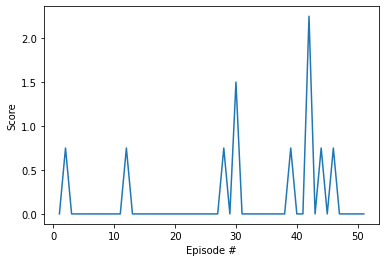

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()